# **Exploratory Data Analysis** 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,8
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\hassa\OneDrive\Desktop\spiced_excercises\scikit-cilantro-student-code\week_07\data\TG_STAID002759.csv', index_col=0,parse_dates=True)

In [3]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-04-26,111448,115,0
2022-04-27,111448,121,0
2022-04-28,111448,115,0


In [4]:
df.describe()

,SOUID,TG,Q_TG
count,53446.000000,53446.000000,53446.000000
mean,119344.482131,57.066403,0.032856
std,8023.626413,613.589338,0.542657
min,111448.000000,-9999.000000,0.000000
25%,111448.000000,33.000000,0.000000
50%,111448.000000,93.000000,0.000000
75%,127488.000000,157.000000,0.000000
max,128124.000000,305.000000,9.000000


<AxesSubplot:xlabel='DATE'>

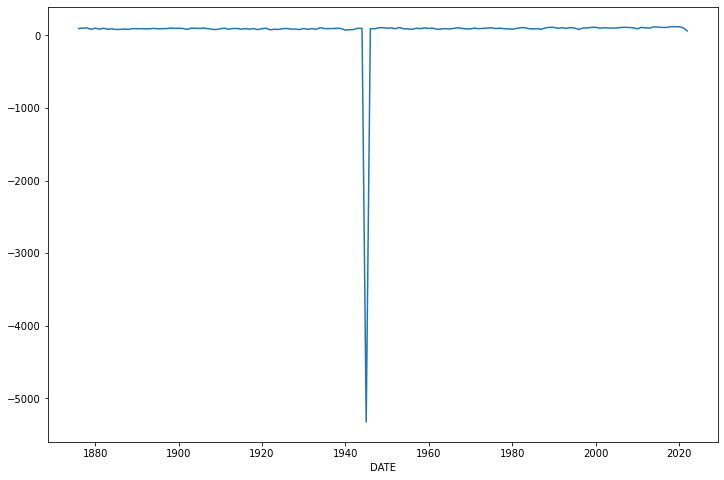

In [5]:
# Find out the missing value
df.groupby(df.index.year)['TG'].mean().plot()

Interpolate the missing value for war years

In [6]:
prior_year = df["1944-04-25": "1944-11-05"]["TG"].to_numpy()
post_year =  df["1946-04-25": "1946-11-05"]["TG"].to_numpy()
war_year = (prior_year + post_year)/2
df.loc["1945-04-25":"1945-11-05","TG"] = war_year

<AxesSubplot:xlabel='DATE'>

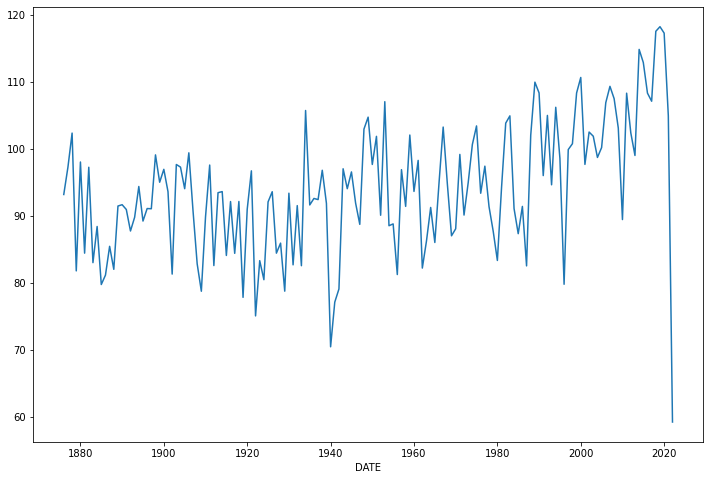

In [7]:
df.groupby(df.index.year)['TG'].mean().plot()

In [8]:
df.drop(['SOUID', 'Q_TG'], axis=1, inplace=True)

In [9]:
df['TG'] = df['TG']*0.1 

In [10]:
df

,TG
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2022-04-26,11.5
2022-04-27,12.1
2022-04-28,11.5


In [11]:
# Performing the train and test split of the data set
df_train = df[:-365]
df_test = df[-365:]

In [12]:
# Add timestep feature - for modeling trend
df_train['timestep'] = range(len(df_train))
df_train

,TG,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4
...,...,...
2021-04-26,5.0,53076
2021-04-27,7.2,53077
2021-04-28,10.9,53078


<AxesSubplot:xlabel='DATE'>

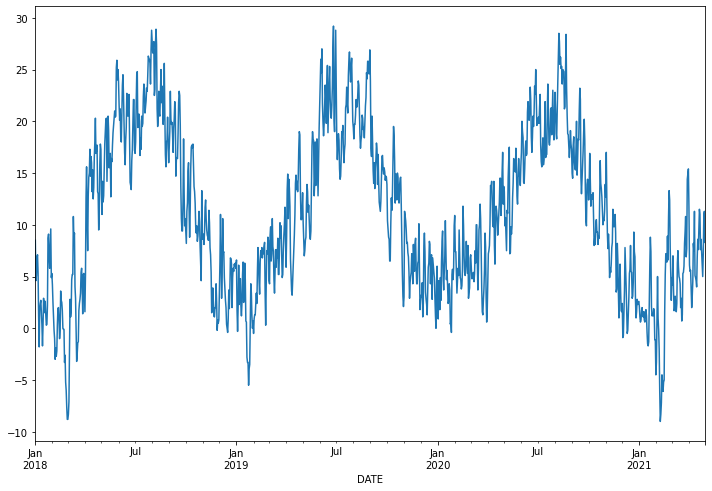

In [13]:
df_train.loc['2018-01-01':]['TG'].plot()

<AxesSubplot:xlabel='DATE'>

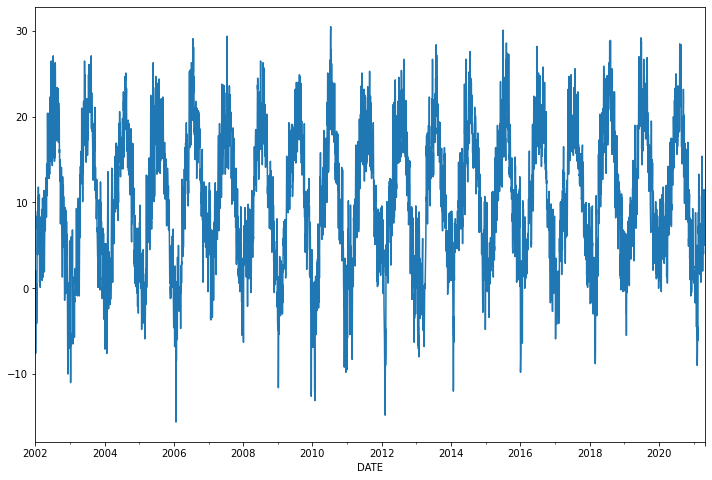

In [14]:
df_train.loc['2002-01-01':]['TG'].plot() 

In [15]:
df1 = df_train["1876"]
df2 = df_train["1900"]
df3 = df_train["1950"]
df4 = df_train["2000"]
df5 = df_train["2020"]

<AxesSubplot:xlabel='DATE'>

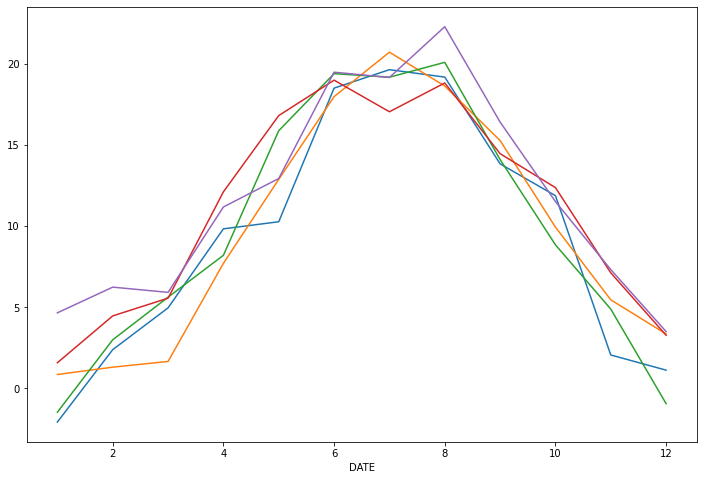

In [16]:
# Aggregate by monthly means
df1.groupby(df1.index.month)['TG'].mean().plot()
df2.groupby(df2.index.month)['TG'].mean().plot()
df3.groupby(df3.index.month)['TG'].mean().plot()
df4.groupby(df4.index.month)['TG'].mean().plot()
df5.groupby(df5.index.month)['TG'].mean().plot()

Checkin for stationarity

In [17]:
statsmodels.tsa.stattools.adfuller(df_train['TG'])

(-20.431221038904177,
 0.0,
 58,
 53022,
 {'1%': -3.4304733377958927,
  '5%': -2.8615945128412337,
  '10%': -2.5667990153705635},
 237612.26212239492)

Given the ADF stats, smaller than -3, conclusion can be drawn that dataset is stationary

# **Feature Engineering, Train & Test Model, Autocorrelation & Partial Autocorrelation, Prediction, AR Models**

In [18]:
# Add seasonal dummies features — for modeling seasonality
seasonal_dummies = pd.get_dummies(df_train.index.month, drop_first=True, prefix='month').set_index(df_train.index)
df_train = df_train.join(seasonal_dummies)

In [19]:
df_train

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
1876-01-01,2.2,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,5.0,53076,0,0,1,0,0,0,0,0,0,0,0
2021-04-27,7.2,53077,0,0,1,0,0,0,0,0,0,0,0
2021-04-28,10.9,53078,0,0,1,0,0,0,0,0,0,0,0


In [29]:
# Define X and y for modeling trend-seasonal component
X = df_train.drop('TG', axis=1)
y = df_train['TG']

In [30]:
# Run linear regression to get trend-seasonal component
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [31]:
# Add trend-seasonal component to the data
df_train['trend_seasonal'] = m.predict(X)

In [32]:
# Add remainder column
df_train['remainder'] = df_train['TG'] - df_train['trend_seasonal']

In [33]:
# Add lag feature — for modeling remainder
df_train['lag1'] = df_train['remainder'].shift(1)

In [34]:
# Define X and y for full model
df_train.dropna(inplace=True)
X_full = df_train.drop(['TG', 'trend_seasonal', 'remainder'], axis=1)
y_full = df_train['TG']

In [35]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [36]:
df_train['full_model'] = m_full.predict(X_full)

<AxesSubplot:xlabel='DATE'>

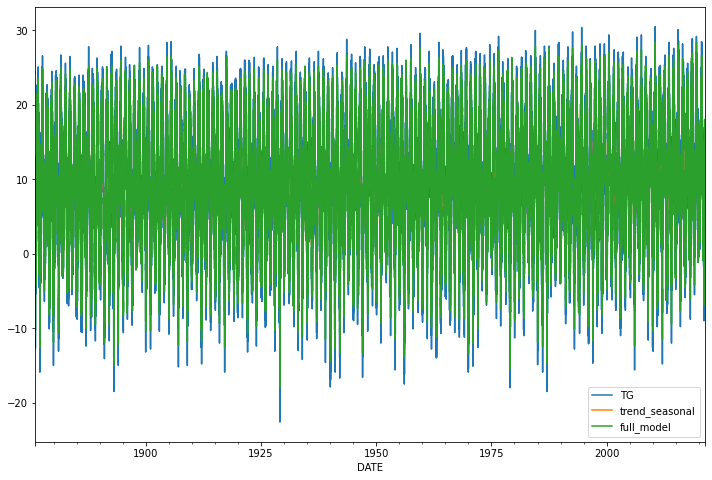

In [37]:
df_train[['TG', 'trend_seasonal', 'full_model']].plot()

In [38]:
df_train['remainder_full_model'] = df_train['TG'] - df_train['full_model']

<AxesSubplot:xlabel='DATE'>

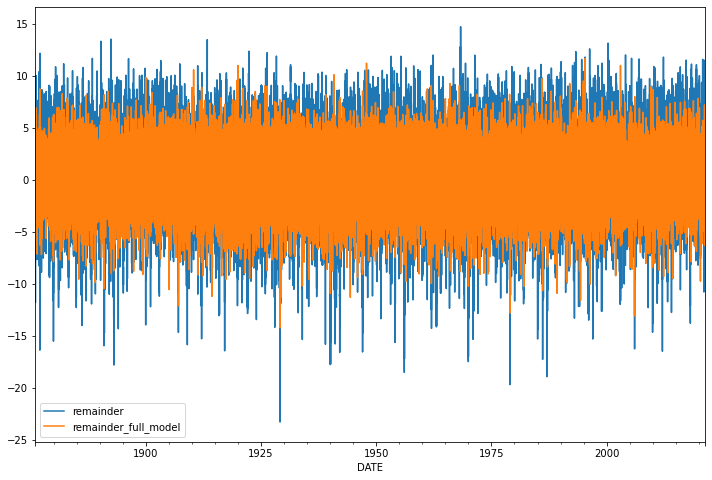

In [39]:
df_train[['remainder', 'remainder_full_model']].plot()

In [40]:
df_train.drop('remainder_full_model', axis=1, inplace=True)
df_train

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,3.069511,1.627366
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,5.0,53076,0,0,1,0,0,0,0,0,0,0,0,9.719021,-4.719021,-3.418988,6.967371
2021-04-27,7.2,53077,0,0,1,0,0,0,0,0,0,0,0,9.719053,-2.519053,-4.719021,5.922237
2021-04-28,10.9,53078,0,0,1,0,0,0,0,0,0,0,0,9.719086,1.180914,-2.519053,7.690943


In [41]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [42]:
# See how the folds work: 
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index[0]} to {train_index[-1]}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index[0]} to {validation_index[-1]}')
    print()

The training data for the 1th iteration are the observations 0 to 8849
The validation data for the 1th iteration are the observations 8850 to 17695

The training data for the 2th iteration are the observations 0 to 17695
The validation data for the 2th iteration are the observations 17696 to 26541

The training data for the 3th iteration are the observations 0 to 26541
The validation data for the 3th iteration are the observations 26542 to 35387

The training data for the 4th iteration are the observations 0 to 35387
The validation data for the 4th iteration are the observations 35388 to 44233

The training data for the 5th iteration are the observations 0 to 44233
The validation data for the 5th iteration are the observations 44234 to 53079



In [43]:
time_series_split = ts_split.split(X_full, y_full)

In [44]:
for a, b in time_series_split:
    print('train set row numbers: ', a)
    print('validation set row numbers: ', b)
    print()

train set row numbers:  [   0    1    2 ... 8847 8848 8849]
validation set row numbers:  [ 8850  8851  8852 ... 17693 17694 17695]

train set row numbers:  [    0     1     2 ... 17693 17694 17695]
validation set row numbers:  [17696 17697 17698 ... 26539 26540 26541]

train set row numbers:  [    0     1     2 ... 26539 26540 26541]
validation set row numbers:  [26542 26543 26544 ... 35385 35386 35387]

train set row numbers:  [    0     1     2 ... 35385 35386 35387]
validation set row numbers:  [35388 35389 35390 ... 44231 44232 44233]

train set row numbers:  [    0     1     2 ... 44231 44232 44233]
validation set row numbers:  [44234 44235 44236 ... 53077 53078 53079]



In [144]:
# Getting error: list index out of range
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)
round(result.mean(), 2)

In [46]:
df_train = df_train.copy()

In [47]:
df_train

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,3.069511,1.627366
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,5.0,53076,0,0,1,0,0,0,0,0,0,0,0,9.719021,-4.719021,-3.418988,6.967371
2021-04-27,7.2,53077,0,0,1,0,0,0,0,0,0,0,0,9.719053,-2.519053,-4.719021,5.922237
2021-04-28,10.9,53078,0,0,1,0,0,0,0,0,0,0,0,9.719086,1.180914,-2.519053,7.690943


In [48]:
# We need to create the timestamp feature for test set that continues on to the timestep for the training set...
last_train_timestep = df_train['timestep'][-1]

In [49]:
df_test['timestep'] = range(last_train_timestep+1, last_train_timestep+1+len(df_test))

In [50]:
last_train_timestep

53080

In [51]:
df_test

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2021-05-01,9.2,53081,0,0,0,1,0,0,0,0,0,0,0
2021-05-02,8.1,53082,0,0,0,1,0,0,0,0,0,0,0
2021-05-03,7.4,53083,0,0,0,1,0,0,0,0,0,0,0
2021-05-04,10.1,53084,0,0,0,1,0,0,0,0,0,0,0
2021-05-05,8.8,53085,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,11.5,53441,0,0,1,0,0,0,0,0,0,0,0
2022-04-27,12.1,53442,0,0,1,0,0,0,0,0,0,0,0
2022-04-28,11.5,53443,0,0,1,0,0,0,0,0,0,0,0


In [52]:
seasonal_dummies = pd.get_dummies(df_test.index.month, drop_first=True, prefix='month').set_index(df_test.index)

In [ ]:
df_test = df_test.join(seasonal_dummies)

In [26]:
df_test

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,
2021-05-01,9.2,53081,0,0,0,1,0,0,0,0,0,0,0
2021-05-02,8.1,53082,0,0,0,1,0,0,0,0,0,0,0
2021-05-03,7.4,53083,0,0,0,1,0,0,0,0,0,0,0
2021-05-04,10.1,53084,0,0,0,1,0,0,0,0,0,0,0
2021-05-05,8.8,53085,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,11.5,53441,0,0,1,0,0,0,0,0,0,0,0
2022-04-27,12.1,53442,0,0,1,0,0,0,0,0,0,0,0
2022-04-28,11.5,53443,0,0,1,0,0,0,0,0,0,0,0


In [54]:
# Assign X_test
X_test = df_test.drop('TG', axis=1)

In [55]:
# Predict trend-seasonal component
df_test['trend_seasonal'] = m.predict(X_test)

<AxesSubplot:xlabel='DATE'>

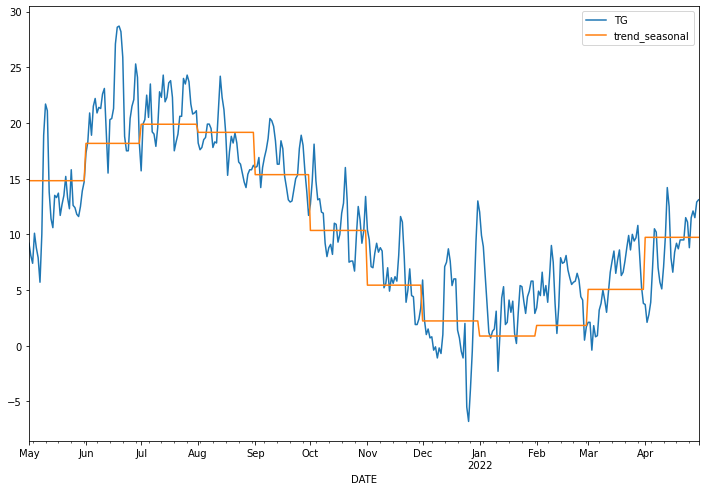

In [56]:
df_test[['TG', 'trend_seasonal']].plot()

In [60]:
# Calculate the remainder
df_test['remainder'] = df_test['TG'] - df_test['trend_seasonal']

In [62]:
# Add the lag1 feature
df_test['lag1'] = df_test['remainder'].shift(1)

In [63]:
# Fill in the NaN in the lag1 column
df_test.loc['2021-05-01', 'lag1'] = df_train.loc['2021-04-30', 'remainder']

In [64]:
# Assign X_full
X_full = df_test.drop(['TG', 'trend_seasonal', 'remainder'], axis=1)

In [65]:
# Create predictions
df_test['full_model'] = m_full.predict(X_full)

In [66]:
df_test

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
2021-05-01,9.2,53081,0,0,0,1,0,0,0,0,0,0,0,14.816497,-5.616497,-1.419151,13.671363
2021-05-02,8.1,53082,0,0,0,1,0,0,0,0,0,0,0,14.816530,-6.716530,-5.616497,10.296920
2021-05-03,7.4,53083,0,0,0,1,0,0,0,0,0,0,0,14.816563,-7.416563,-6.716530,9.412576
2021-05-04,10.1,53084,0,0,0,1,0,0,0,0,0,0,0,14.816595,-4.716595,-7.416563,8.849814
2021-05-05,8.8,53085,0,0,0,1,0,0,0,0,0,0,0,14.816628,-6.016628,-4.716595,11.020498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,11.5,53441,0,0,1,0,0,0,0,0,0,0,0,9.730915,1.769085,-0.930883,8.979590
2022-04-27,12.1,53442,0,0,1,0,0,0,0,0,0,0,0,9.730948,2.369052,1.769085,11.150274
2022-04-28,11.5,53443,0,0,1,0,0,0,0,0,0,0,0,9.730980,1.769020,2.369052,11.632653


In [67]:
df_full = df_train[['TG', 'trend_seasonal', 'full_model']]\
    .append(df_test[['TG', 'trend_seasonal', 'full_model']])

In [68]:
df_full

,TG,trend_seasonal,full_model
DATE,,,
1876-01-02,2.5,-0.869478,1.627366
1876-01-03,0.3,-0.869445,1.868558
1876-01-04,-5.8,-0.869413,0.099865
1876-01-05,-9.8,-0.869380,-4.804252
1876-01-06,-7.7,-0.869348,-8.020064
...,...,...,...
2022-04-26,11.5,9.730915,8.979590
2022-04-27,12.1,9.730948,11.150274
2022-04-28,11.5,9.730980,11.632653


<AxesSubplot:xlabel='DATE'>

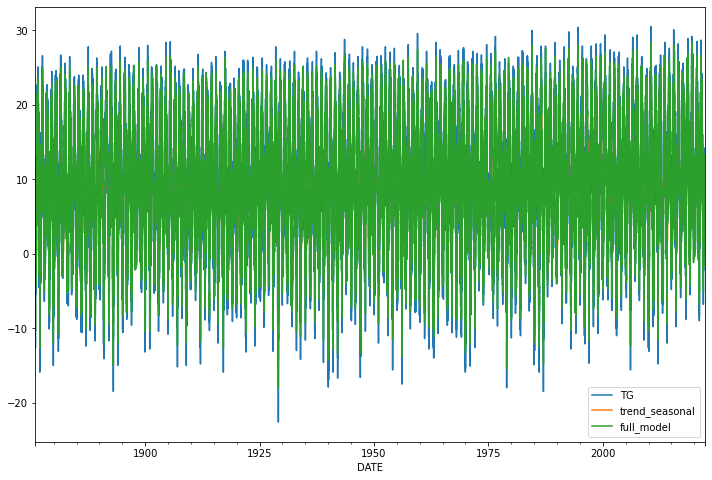

In [69]:
df_full.plot()

In [70]:
round(m_full.score(X_full, df_test['TG']), 3)

0.915

In [71]:
# Combine the datasets
df_combined = df_train.append(df_test)

In [72]:
df_combined

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,3.069511,1.627366
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,11.5,53441,0,0,1,0,0,0,0,0,0,0,0,9.730915,1.769085,-0.930883,8.979590
2022-04-27,12.1,53442,0,0,1,0,0,0,0,0,0,0,0,9.730948,2.369052,1.769085,11.150274
2022-04-28,11.5,53443,0,0,1,0,0,0,0,0,0,0,0,9.730980,1.769020,2.369052,11.632653


In [73]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['TG', 'remainder', 'trend_seasonal', 'full_model']) # , 'trend_seasonal', 'remainder', 'full_model'])
y_combined = df_combined['TG']

In [74]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [75]:
X_combined.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1'],
      dtype='object')

In [76]:
df_combined

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,3.069511,1.627366
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,11.5,53441,0,0,1,0,0,0,0,0,0,0,0,9.730915,1.769085,-0.930883,8.979590
2022-04-27,12.1,53442,0,0,1,0,0,0,0,0,0,0,0,9.730948,2.369052,1.769085,11.150274
2022-04-28,11.5,53443,0,0,1,0,0,0,0,0,0,0,0,9.730980,1.769020,2.369052,11.632653


In [77]:
# What are the components of the next/future timestep 2022-05-01
timestep = df_combined['timestep'].max() + 1
months = [0] * 11
months[2]=1
lag = df_combined.loc['2022-04-30', 'remainder']

In [78]:
# Create a future data point
X_future1 = []
X_future1.append(timestep)
X_future1.extend(months)
X_future1.append(lag)

In [79]:
X_future1

[53446, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3.3689543296302897]

In [80]:
X_future1 = pd.DataFrame([X_future1], columns = X_combined.columns)

In [81]:
X_future1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,53446,0,0,1,0,0,0,0,0,0,0,0,3.368954


In [82]:
y_future1 = m_combined.predict(X_future1)
y_future1

array([12.43988201])

In [88]:
df_train

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,3.069511,1.627366
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,5.0,53076,0,0,1,0,0,0,0,0,0,0,0,9.719021,-4.719021,-3.418988,6.967371
2021-04-27,7.2,53077,0,0,1,0,0,0,0,0,0,0,0,9.719053,-2.519053,-4.719021,5.922237
2021-04-28,10.9,53078,0,0,1,0,0,0,0,0,0,0,0,9.719086,1.180914,-2.519053,7.690943


In [89]:
m.predict(X)

array([-0.86951064, -0.86947805, -0.86944546, ...,  9.71908574,
        9.71911832,  9.71915091])

In [90]:
m.coef_, m.intercept_

(array([3.25883773e-05, 9.50926081e-01, 4.18540906e+00, 8.85887049e+00,
        1.39561844e+01, 1.73056551e+01, 1.90235291e+01, 1.82940762e+01,
        1.44955650e+01, 9.48488029e+00, 4.56978401e+00, 1.35677449e+00]),
 -0.8695106415871354)

In [91]:
X_remainder = df_train.drop('TG', axis = 1)
y_remainder = df_train['TG']

In [92]:
df_train['remainder'] = df_train['TG'] - df_train['trend_seasonal']

In [93]:
df_train['remainder'].to_csv('data/weather_remainder.csv')
df_remainder = pd.read_csv (r'data/weather_remainder.csv')
df_remainder

,DATE,remainder
0,1876-01-02,3.369478
1,1876-01-03,1.169445
2,1876-01-04,-4.930587
3,1876-01-05,-8.930620
4,1876-01-06,-6.830652
...,...,...
53075,2021-04-26,-4.719021
53076,2021-04-27,-2.519053
53077,2021-04-28,1.180914
53078,2021-04-29,1.580882


In [94]:
df_train['lag1'] = df_train['remainder'].shift(1)

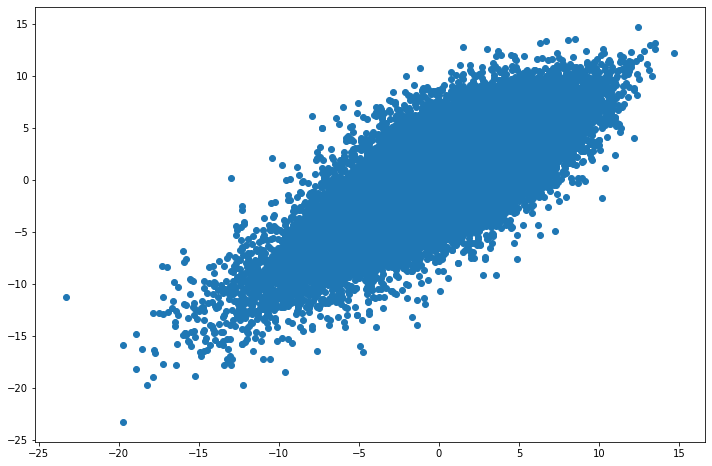

In [95]:
plt.scatter(data=df_train, x='remainder', y='lag1')

<AxesSubplot:>

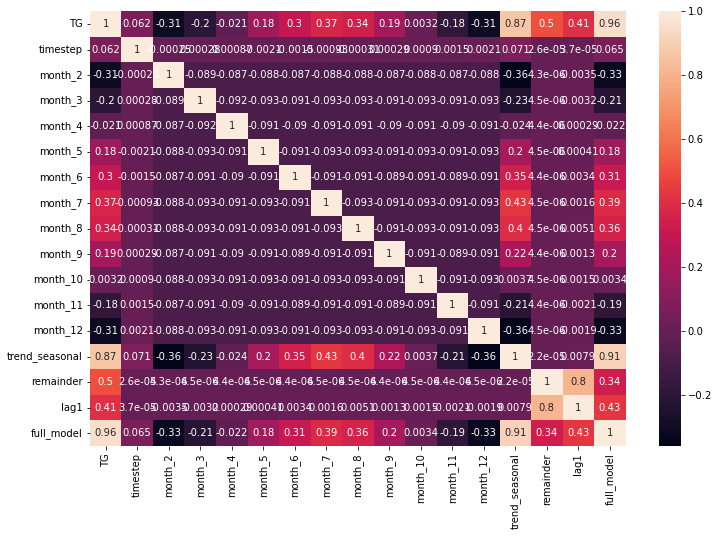

In [96]:
sns.heatmap(df_train.corr(), annot=True)

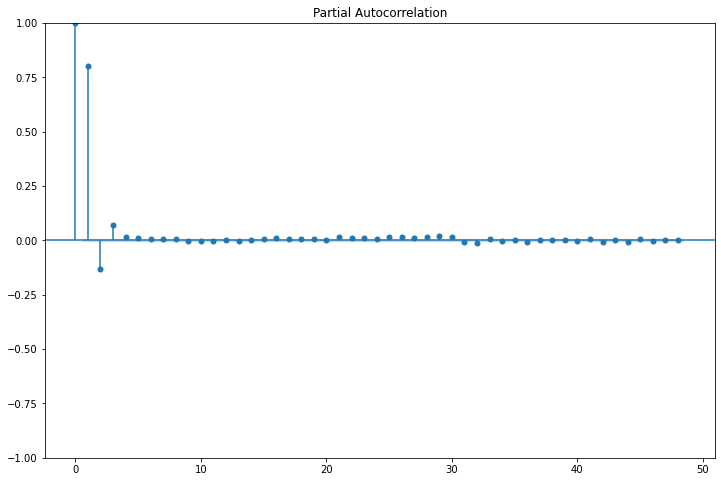

In [97]:
plot_pacf(df_remainder['remainder']);

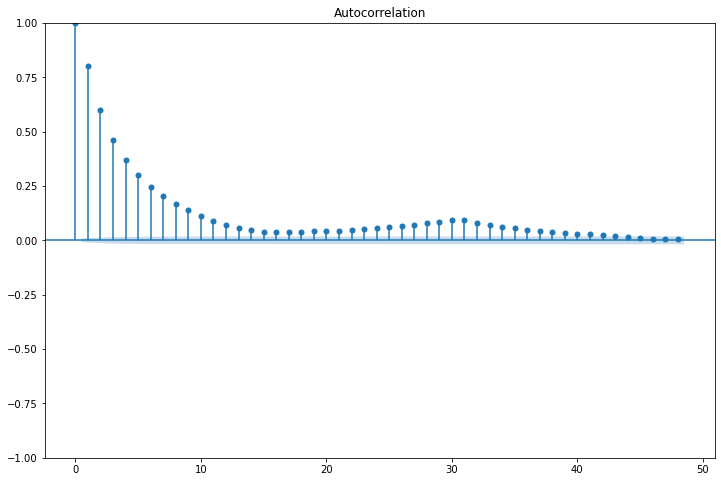

In [98]:
plot_acf(df_remainder['remainder']);

In [125]:
selected_order = ar_select_order(df_train['remainder'], maxlag=5)
selected_order.ar_lags

[1, 2, 3, 4]

In [126]:
selected_order.bic

{(1, 2, 3, 4): 239500.06037576997,
 (1, 2, 3, 4, 5): 239501.97622605177,
 (1, 2, 3): 239503.3517151783,
 (1, 2): 239752.1897080735,
 (1,): 240683.8535829167,
 0: 295827.4507038807}

In [127]:
ar_model = AutoReg(endog=df_train['remainder'], lags=1).fit()

In [128]:
df_train

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model,prediction_sm,ar_pred
DATE,,,,,,,,,,,,,,,,,,,
1876-01-02,2.5,1,0,0,0,0,0,0,0,0,0,0,0,-0.869478,3.369478,NaN,1.627366,NaN,NaN
1876-01-03,0.3,2,0,0,0,0,0,0,0,0,0,0,0,-0.869445,1.169445,3.369478,1.868558,2.708592,2.708592
1876-01-04,-5.8,3,0,0,0,0,0,0,0,0,0,0,0,-0.869413,-4.930587,1.169445,0.099865,0.940009,0.940009
1876-01-05,-9.8,4,0,0,0,0,0,0,0,0,0,0,0,-0.869380,-8.930620,-4.930587,-4.804252,-3.963744,-3.963744
1876-01-06,-7.7,5,0,0,0,0,0,0,0,0,0,0,0,-0.869348,-6.830652,-8.930620,-8.020064,-7.179328,-7.179328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,5.0,53076,0,0,1,0,0,0,0,0,0,0,0,9.719021,-4.719021,-3.418988,6.967371,-2.748585,-2.748585
2021-04-27,7.2,53077,0,0,1,0,0,0,0,0,0,0,0,9.719053,-2.519053,-4.719021,5.922237,-3.793668,-3.793668
2021-04-28,10.9,53078,0,0,1,0,0,0,0,0,0,0,0,9.719086,1.180914,-2.519053,7.690943,-2.025137,-2.025137


<AxesSubplot:xlabel='DATE'>

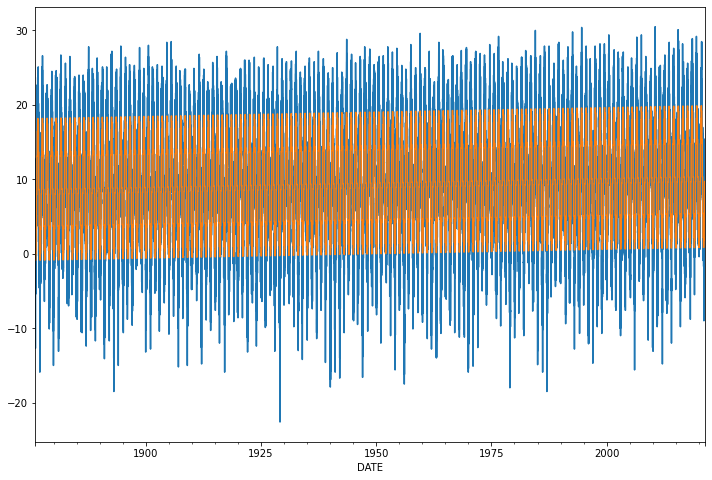

In [141]:
df_train['TG'].plot()
df_train['trend_seasonal'].plot()

In [129]:
df_train['prediction_sm'] = ar_model.predict() 

<AxesSubplot:xlabel='DATE'>

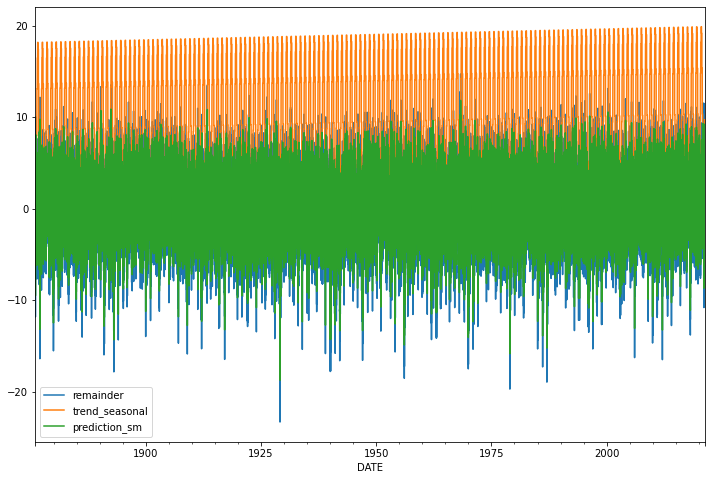

In [130]:
df_train[['remainder', 'trend_seasonal', 'prediction_sm']].plot()

In [131]:
df_test['remainder'] = df_test['TG'] - df_test['trend_seasonal']
df_test.head()

,TG,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,full_model
DATE,,,,,,,,,,,,,,,,,
2021-05-01,9.2,53081,0,0,0,1,0,0,0,0,0,0,0,14.816497,-5.616497,-1.419151,13.671363
2021-05-02,8.1,53082,0,0,0,1,0,0,0,0,0,0,0,14.816530,-6.716530,-5.616497,10.296920
2021-05-03,7.4,53083,0,0,0,1,0,0,0,0,0,0,0,14.816563,-7.416563,-6.716530,9.412576
2021-05-04,10.1,53084,0,0,0,1,0,0,0,0,0,0,0,14.816595,-4.716595,-7.416563,8.849814
2021-05-05,8.8,53085,0,0,0,1,0,0,0,0,0,0,0,14.816628,-6.016628,-4.716595,11.020498


In [132]:
df_train['ar_pred'] = ar_model.predict()
df_train['ar_pred']

DATE
1876-01-02         NaN
1876-01-03    2.708592
1876-01-04    0.940009
1876-01-05   -3.963744
1876-01-06   -7.179328
                ...   
2021-04-26   -2.748585
2021-04-27   -3.793668
2021-04-28   -2.025137
2021-04-29    0.949228
2021-04-30    1.270758
Name: ar_pred, Length: 53080, dtype: float64

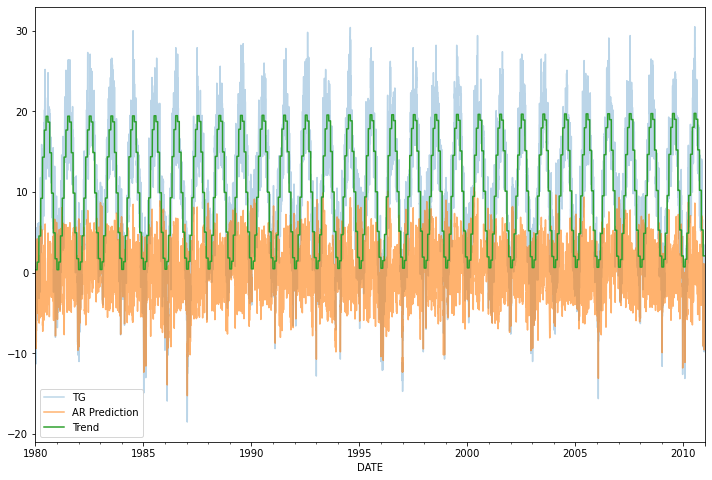

In [133]:
df_train['1980':'2010']['TG'].plot(alpha = 0.3, label = "TG")
df_train['1980':'2010']['ar_pred'].plot(alpha = 0.6, label = "AR Prediction")
df_train['1980':'2010']['trend_seasonal'].plot(alpha = 1, label = "Trend")
plt.legend()

In [139]:
ar = AutoReg(df['TG'], lags = 5).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                     TG   No. Observations:                53446
Model:                     AutoReg(5)   Log Likelihood             -120413.467
Method:               Conditional MLE   S.D. of innovations              2.303
Date:                Sun, 26 Jun 2022   AIC                         240840.934
Time:                        15:26:15   BIC                         240903.139
Sample:                    01-06-1876   HQIC                        240860.359
                         - 04-30-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3195      0.016     20.085      0.000       0.288       0.351
TG.L1          0.9906      0.004    229.774      0.000       0.982       0.999
TG.L2         -0.2000      0.006    -32.906      0.000      -0.212      -0.188
TG.L3          0.0877      0.006     14.314      0.000       0.076       0.100
TG.L4          0.0065      0.006      1.072      0.284      -0.005       0.018
TG.L5          0.0813      0.004     18.853      0.000       0.073       0.090
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0259           -0.0000j            1.0259           -0.0000
AR.2            0.8693           -1.3852j            1.6353           -0.1608
AR.3            0.8693           +1.3852j            1.6353            0.1608
AR.4           -1.4223           -1.5691j            2.1178           -0.3672
AR.5           -1.4223           +1.5691j            2.1178            0.3672
-----------------------------------------------------------------------------
"""

In [135]:
ar_model = AutoReg(endog=df_train['TG'], lags=5).fit()
ar_model

In [137]:
arima_model = ARIMA(endog=df['TG'], order =(2,1,2)).fit()
arima_model

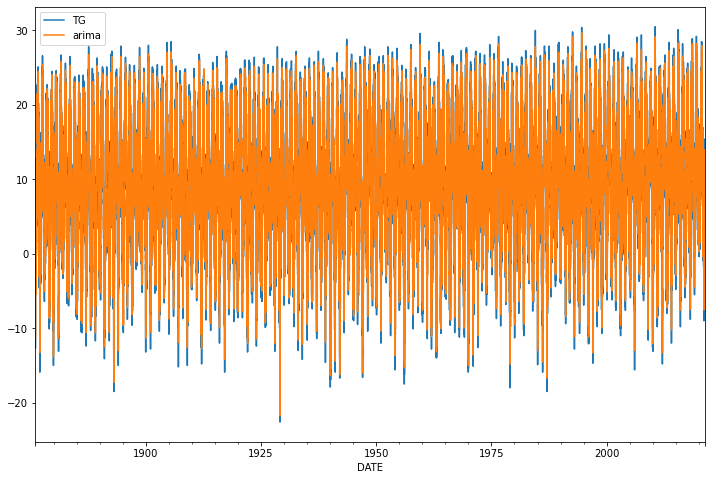

In [152]:
df_train['TG'].plot()
plt.plot(arima_model.predict(), label='arima')
plt.legend()
plt.show()

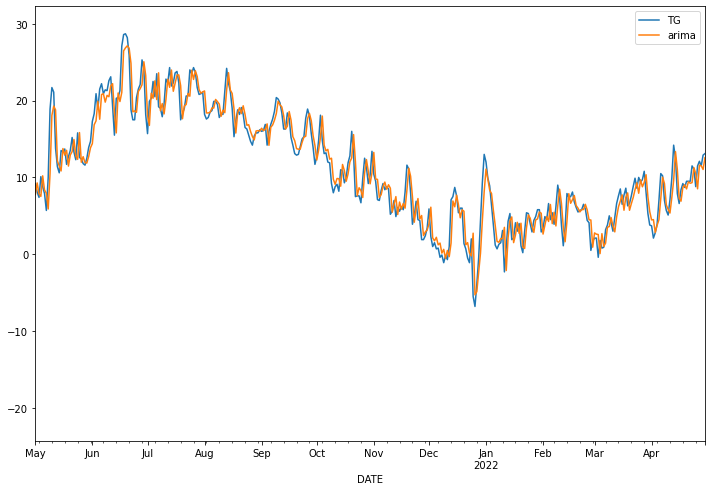

In [153]:
df_test['TG'].plot()
plt.plot(arima_model.predict(), label='arima')
plt.legend()
plt.show()